In [1]:
# D Duncan 09/01/19
# The idea here is to read in the atmospheric state from CSU1DVAR output
#  files and calculate ad-hoc calibration offsets for the low frequency 
#  channels using FASTEM and TESSEM with the ARTS model.
# Code originally copied from am2var_v1-sfcr.ipynb

In [2]:
# set some switches for how the simulations will be done:

use_tes = False  # use tessem or fastem  (tessem isn't supposed to work below 10GHz!)
use_era = False # use era5 for wv, wind, sst,  or use 1dvar as input

err='1dvar' # just string for output files, either era5 or 1dvar indicating input data
if use_era: err='ERA5'

# Set up ARTS/Python environment


In [3]:
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/

%matplotlib inline
import glob
from h5py import File
from netCDF4 import Dataset

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [4]:
from typhon.arts.workspace.variables import *

ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )

ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
# used to debug with sensor position and things:
#@arts_agenda
#def iy_main_agendaPY(ws):
#    ws.ppathCalc()
#    ws.iyEmissionStandard()
#    ws.Print(ws.ppath,0)
#ws.Copy( ws.iy_main_agenda, iy_main_agendaPY)
    
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [5]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
ws.abs_lines_per_speciesSetEmpty()

# General Settings

In [6]:
ws.stokes_dim = 2 # to get V and H pol out of metmm
ws.iy_unit = "PlanckBT" # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

# Atmosphere set up # (take Psfc, T from model later)

In [7]:
from typhon.physics.atmosphere import integrate_water_vapor
ws.atmosphere_dim = 1  # for 1DVAR
p = np.array([1000.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
print(len(p))
ws.p_grid = p[:] #0.5 * (p[1:] + p[:-1])
print(ws.p_grid.value)
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
# WV given as VMR
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]
trop_ss, trop_t = np.copy(ws.t_surface.value), np.copy(ws.t_field.value[:,0,0])
z = ws.z_field.value[:, 0, 0]
#print(ws.t_field.value)

factor = 28.966/18.016 * 0.001 # convert WV mixing ratio (g/kg) to vmr (mol/mol)
trop_vmr = np.copy(ws.vmr_field.value[0,:,0,0])
print('trop vmr:',trop_vmr, info(trop_vmr))
mr_mngr = np.asarray(ws.vmr_field)[0,:,0,0]/factor # should yield g/kg
# sum(1.0/(1000.0*9.81) * apecmr(:)*(dp(:))*100.0) # TPW from MR (from 1dvar code)

dp = [p[x]-p[x+1] for x in range(len(p)-1)]
print(dp)
#tpw_init = np.sum(1.0/(1000.0*9.81) * mr_mngr[:-1]*dp)#, dp)
#print(tpw_init)
dz = np.diff(z)
mmr = 0.5 * (mr_mngr[1:] + mr_mngr[:-1])
#tpw_init = np.trapz(1.0/(1000.0*9.81) * mr_mngr[:-1]*dp)#, dp)


wvc = integrate_water_vapor(ws.vmr_field.value[0, :, 0, 0], ws.p_grid.value)
#print(tpw_init)
print(wvc)

17
[100000.  97500.  95000.  92500.  90000.  85000.  80000.  75000.  70000.
  65000.  60000.  55000.  50000.  40000.  30000.  20000.  10000.]
trop vmr: [2.52196149e-02 2.37858298e-02 2.23147994e-02 2.08045368e-02
 1.93452537e-02 1.72987546e-02 1.49967833e-02 1.13252834e-02
 7.88189193e-03 5.34901910e-03 3.97190372e-03 3.19044020e-03
 2.26046337e-03 9.87003039e-04 2.65972393e-04 2.14005006e-05
 2.94033094e-06] ['2.94E-6', '2.52E-2', '1.05E-2', '9.06E-3']
[2500.0, 2500.0, 2500.0, 2500.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 10000.0, 10000.0, 10000.0, 10000.0]
39.631092634692116


# Sensor definition -- AMSR2 sensor setup w/ metmm

In [8]:
ws.ArrayOfIndexCreate("channels")
# initial sensor setup, all 13 channels at low frequency EIA
nlo = 14
#csub = [[x for x in range(nlo)], [x+nlo for x in range(2)]] # 16 AMSR2 channels total
csub = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13],[]] # so 6 to 89GHz (no b-scan)
#csub = [[0,1,2,3,4,5,6,7],[]] # so 6.9V/H, 7.3V/H, 10V/H, 18V/H
#csub = [ [3,4,5,6], [11,12] ]#  define channel indices (0-8 10-89GHz, 9-12 166-183GHz)
nch = np.size(np.ravel(csub[0]+csub[1]))
print('# channels using: ',nch)
#ws.channels = csub #[0,:]+csub[1,:] #list(np.ravel(csub)) # 23.8 and 183 channels only for WV

ws.ArrayOfIndexCreate("viewing_angles") # necessary if just using one pencil beam angle?
#ws.viewing_angles = [1] # index of viewing angles in metmm file -- for AMSR2 only B-scan is different
# current setup is low freqs at index 1, high freqs at index 0

ws.sensor_pos  = np.array([[699.6e3]]) # altitude [taken from h5 header BELOW!!!]
#can take exact alt from file if desired, same with lat/lon values (does that have effect?)
ws.sensor_time = np.array([0.0]) # same here
ws.sensor_los  = np.array([[180.0]]) # since angle taken care of in metmm file 
# zenith angle followed by azimuth. zenith=0 is straight up, 180 is straight down. azimuth=0 is N, positive to east 

ws.IndexCreate("met_mm_accuracy") 
ws.met_mm_accuracy = 2 # points within each bandwidth to comute abs characteristics


# channels using:  14


# Perform some checks

In [9]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
#ws.abs_lookupSetup() # not currently using lookup tables (on the fly instead)
#ws.abs_lookupCalc()

In [10]:
# Read in CSU 1DVAR output file to get SST, LWP, TPW, and WS to run simulation
# (T will have to be assumed or taken from ERA5)
file = '/home/dudavid/projects/1dvar/old_am2/out.nc'
f = Dataset(file)
ss = f['sea_surface_subskin_temperature'][:]
tp = f['atmosphere_mass_content_of_water_vapor'][:]
wi = f['wind_speed'][:] # dont use 'ws'!
lw = f['atmosphere_mass_content_of_cloud_liquid_water'][:]
ch = f['chi_squared'][:]
lo = f['longitude'][:]
la = f['latitude'][:]
print(np.shape(ch))
#sel = np.logical_and(tp > 0, ch < 0.5)
#clr = [lw[sel] < 10]
#print(shinfo(wi[sel][clr])) #,info(ws[sel]))

(243, 1981)


In [11]:
print(shinfo(lw[np.logical_and(lw<12,lw>0)]))
print(shinfo(lw[np.logical_and(lw>0,lw>0)]))

['1.60E-2', '1.20E+1', '1.30E+0', '1.45E+0', (191884,)]
['1.60E-2', '1.32E+3', '4.03E+1', '1.10E+2', (267126,)]


In [12]:
# Read in the corresponding AM2 L1R file from JAXA to get original TBs
#apath = '/home/dudavid/src/1dvar/ocean_goes5_AMSR2/'
afile = '/home/dudavid/src/1dvar/ocean_goes5_AMSR2/GW1AM2_201609211515_089A_L1SGRTBR_2220220.h5'
dorb = afile[-35:-20]
amf = File(afile)

altitude = 1e3* float(bytes.decode(amf.attrs['SatelliteAltitude'][0])[:-2])
print(altitude,'m')
ws.sensor_pos = np.array([[ altitude ]]) # set to correct satellite altitude [m]
# choose channels and convolution resolution (these are native except 89!)
tblist = ['Brightness Temperature (res06,6.9GHz,V)','Brightness Temperature (res06,6.9GHz,H)',\
          'Brightness Temperature (res06,7.3GHz,V)','Brightness Temperature (res06,7.3GHz,H)',\
          'Brightness Temperature (res10,10.7GHz,V)','Brightness Temperature (res10,10.7GHz,H)',\
          'Brightness Temperature (res23,18.7GHz,V)','Brightness Temperature (res23,18.7GHz,H)',\
          'Brightness Temperature (res23,23.8GHz,V)','Brightness Temperature (res23,23.8GHz,H)',\
          'Brightness Temperature (res36,36.5GHz,V)','Brightness Temperature (res36,36.5GHz,H)',\
          'Brightness Temperature (res36,89.0GHz,V)','Brightness Temperature (res36,89.0GHz,H)' ] 
nch = len(tblist)
ch_str = ['6V','6H','7V','7H','10V','10H','18V','18H','23V','23H','36V','36H','89V','89H']
npix = 243
nscans = np.shape(amf[tblist[0]][:])[0] 
print(nscans)
tbs = np.zeros([npix,nscans,nch])
for c,chstr in enumerate(tblist):
    tbs[:,:,c] = .01 * amf[chstr][:,:].transpose()  # tbs saved with factor 100

# NOTE: there are 30 'overlap' scans included on either end of JAXA files, 
#  so we shrink this array to match 1dvar output thus:
nscans -= 30*2
tbs = tbs[:, 30:-30, :].reshape(nscans*npix,nch)
print(shinfo(tbs),nscans)    

#alo = amf['Longitude of Observation Point for 89A'][:].transpose()[::2,30:-30]
#ala = amf['Latitude of Observation Point for 89A'][:].transpose()[::2,30:-30]
#print(info(alo-lo))
#print(info(ala-la))

699600.0 m
2041
['7.47E+1', '3.75E+2', '1.87E+2', '5.49E+1', (481383, 14)] 1981


In [30]:
# calibration offsets (L1 Tb + offset... so negative offsets indicate L1 is too high)

# from xcal table file, following same conventions: "# The inter-calibration table consists of a series of tie points for each channel. The table contains two lines
# of information for each channel. The first column contains the channel number from 1 to N and the second
# column contains the number of tie points for that channel. The remaining values in the first line consist of
# the temperature values in Kelvin for each tie point and the second line contains the calibration offset
# values in Kelvin for each tie point. Note that the resulting offset values are added to added to the Tb.

#### the values are just in channel order, from 6V to 89H  (left is V, right H)
####   and to keep separate the GPM and empirical offsets, GPM/1DVAR is first for each (6V/H and 23H DD-only)
ch_off_c = [-0.42 -0.41, -2.15 -1.21,\
             0.00 -1.02,  0.00 -3.91,\
            -4.23 -0.16, -2.99 -2.18,\
            -5.30, -2.74,\
            -4.69, -3.70,\
            -2.51, -4.55,\
            -0.76, -2.29,\
            -1.14, -1.79] 
# for low freqs, numbers are just copied from cold cal point
ch_off_h = [-0.83, -3.36,\
            -1.00, -3.91,\
            -0.96, -0.80,\
            -0.45, -0.09,\
            -1.54, -3.70,\
            -0.29, -0.31,\
            -0.02, -0.11,\
            -0.20, -0.22]
ch_off = np.stack([ch_off_c,ch_off_h]).transpose() # into one array for ease
# 'tie points' are in K, corresponding to cold and warm calibration offset scene values
#  [these will differ from GPM cal table for low freqs]
tie_points = np.asarray([[172,290], [83,290], [172,290], [83,290], [158,290], [83,288], \
                         [174,290], [99,289], [188,291], [87,90],  \
                         [201,288], [130,287],[235,289], [177,289],[235,289],[177,289]])
# tbs modified by these calibration offsets involve a linear interpolation between tie points
#  and constant value outside known values:
np.save('data/caltable_180119_fastem-1dvar_AMSR2_tiepoints.npy',tie_points) # nch x 2 (cold and warm cal points)
np.save('data/caltable_180119_fastem-1dvar_AMSR2_offsets.npy',ch_off) # nch x 2 (cold and warm cal)
tb_cal  = tbs #np.zeros_like(tbs)
for c in range(nch):
    lodex = np.where( tbs[:,c] <= tie_points[c,0] )[0]
    tb_cal[lodex,c] = tbs[lodex,c] + ch_off[c,0]
    hidex = np.where( tbs[:,c] >= tie_points[c,1] )[0]
    tb_cal[hidex,c] = tbs[hidex,c] + ch_off[c,1]
    
    midex = np.logical_and( tbs[:,c] > tie_points[c,0],  tbs[:,c] < tie_points[c,1] )
    tb_cal[midex,c] = tbs[midex,c] + ( ((ch_off[c,1]-ch_off[c,0])/(tie_points[c,1]-tie_points[c,0])) \
                                         *(tbs[midex,c]-tie_points[c,0]) + ch_off[c,0])
    
    #  LESS EFFICIENT (but maybe easier to read?)
    #for x in range(len(tp_sav)):
    #    if tb_obs[x,c]<tie_points[c,0]: 
    #        tb_cal[x,c] = tb_obs[x,c]+ch_off[c,0]
    #    if tb_obs[x,c]>tie_points[c,1]: 
    #        tb_cal[x,c] = tb_obs[x,c]+ch_off[c,1]
    #    if tb_obs[x,c]>tie_points[c,0] and tb_obs[x,c]<tie_points[c,1]:    # using y=mx+b form:
    #        tb_cal[x,c] = tb_obs[x,c] + ( ((ch_off[c,1]-ch_off[c,0])/(tie_points[c,1]-tie_points[c,0])) \
    #                                     *(tb_obs[x,c]-tie_points[c,0]) + ch_off[c,0])
print(shinfo(tb_cal))
tb_cal = tb_cal.reshape(npix,nscans,nch)

['5.88E+1', '3.71E+2', '1.76E+2', '5.82E+1', (481383, 14)]


In [14]:
epaf = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/EC/wv1609/'

#import cdsapi
#era5client = cdsapi.Client()
#
#era5client.retrieve(
#    'reanalysis-era5-single-levels',
#    {
#        'product_type':'reanalysis',
#        'format':'netcdf',
#        'variable':[
#            '10m_u_component_of_wind','10m_v_component_of_wind','10m_wind_direction',
#            '2m_dewpoint_temperature','2m_temperature','sea_surface_temperature',
#            'mean_sea_level_pressure'
#        ],
#        'year':'2016',
#        'month':'09',
#        'day':'21',
#        'time':'15:00'
#    },
#    'sfc_vars_210916_15Z.nc')

# read in T and q from ERA5:
era5p = epaf+'testy.nc'
era5s = epaf+'sfc_vars_210916_15Z.nc'
# fields are [time, levels, lat, lon] , so [1,17,721,1440] the way it was downloaded
# this file is 15Z, near the equator crossing time of the same 210916 orbit

era = Dataset(era5p)
era_q = era['q'][0,:,:,:]
era_mr = era_q / (1-era_q)
era_t = era['t'][0,:,:,:]
print(np.shape(era_t))
elo=era['longitude'][:]
ela=era['latitude'][:]
# shift grids from 0-360 lon to -180-180 lons?

eras = Dataset(era5s)
era_wi = ( eras['u10'][0,:,:]**2 + eras['v10'][0,:,:]**2 )**0.5  # get wind speed from vectors [m/s]
print(shinfo(era_wi))
era_wd = eras['dwi'][0,:,:]  # direction of 10m wind [degrees from N]
#era_td = eras['d2m'][:]  # 2m dewpoint temperature [K]   --- not being used right now!
era_ts = eras['t2m'][0,:,:]  # 2m air temperature [K]
print(shinfo(era_ts))
era_sp = eras['msl'][0,:,:]  # mean sea level pressure [Pa]
era_ss = eras['sst'][0,:,:]  # SST [K]
#print(info(era_wd[era_wd>0]))
era_wd[era_wd<0] = 0.0   # for missing values, set to 0 (N)

#grdmap( era_wd,  0, -90, 0, 360, 0)

(17, 721, 1440)
['7.90E-3', '2.69E+1', '6.24E+0', '3.72E+0', (721, 1440)]
['2.06E+2', '3.18E+2', '2.80E+2', '2.18E+1', (721, 1440)]


# Designate surface vars

In [15]:

#ws.NumericCreate("wind_speed")
#ws.NumericCreate("wind_direction")
#ws.wind_speed = 3.9
#ws.surface_skin_t = 290.2
#ws.wind_direction = 0.0 # can adjust based on analysis data later  -- default should be 0
# -- need sensor azimuth angle, and spacecraft heading, as arts azimuth is relative to N
#ws.salinity = .035 # default is .035 anyway

# transmittance only needed for running fastem:
#ws.VectorCreate("transmittance")
#print(ws.f_grid.value)
#ws.transmittance  = np.ones(ws.f_grid.value.shape) # or ones, or something else?
#print('wind speed, SST: ',ws.wind_speed.value,ws.surface_skin_t.value)#ws.t_surface.value.ravel()[0])

# add surface variables for jacobian calculation -- need to keep order consistent between snames/sdata
snames = ["Water skin temperature", "Wind speed", "Salinity", "Wind direction"]
sdata = np.array([299, 3.4, 0.035, 0]).reshape(4,1,1)
#sdata = np.array([ws.surface_skin_t.value, ws.wind_speed.value, 0.035, ws.wind_direction.value]).reshape(4,1,1)
#sdata = np.array([ws.t_surface.value.ravel()[0], ws.wind_speed.value, 0.035]).reshape(3,1,1)

# don't copy to arts variables yet... otherwise ycalc bombs due to SurfaceDummy [old issue]
ws.Copy(ws.surface_props_names, snames)
ws.Copy(ws.surface_props_data, sdata)


nrvar = 2 # num retrieved variables
rvars = np.zeros(nrvar)
rvars[:] = [4.2, 3.9] # corresponding to variable order set above

# set Xa (formally set below)
xa = np.zeros(nrvar) # if supplying user-defined a priori vector
#xa[:] = [ws.surface_skin_t.value, ws.wind_speed.value] # just perturbations from values defined above

# define jacobians, run ycalc 

In [16]:

ws.ArrayOfIndexCreate("viewing_angles_1")
ws.viewing_angles_1 = [0] # index, defined in metmm file
ws.ArrayOfIndexCreate("channels_1") # low freq channels EIA
ws.channels_1 = csub[0]
ws.Copy(ws.viewing_angles, ws.viewing_angles_1)
ws.Copy(ws.channels, ws.channels_1)

# re-execution of metmm control files ( since channels subset and angle have changed)
ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_amsr2.arts") #atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts") # to execute CF?

# NO NEED TO RUN JACOBIAN INIT IF USING RETRIEVAL DEF INIT
#ws.jacobianInit()  # initialize jacobian quantities, then add variables

In [17]:
# if using tessem... read tessem ascii files into arts memory
tez = 'F' # fastem is default
if use_tes:
    ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")
    ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt") 
    tez = 'T'

# if using surfaceFastem, need to provide transmittances and wind direction:
ws.VectorCreate( "transmittance" )
print(ws.f_grid.value)
ws.transmittance = np.ones( ws.f_grid.value.shape )

if use_tes:
    @arts_agenda
    def iy_surface_agendaPY(ws):
        ws.SurfaceTessem()
        ws.iySurfaceRtpropCalc()
else:
    @arts_agenda
    def iy_surface_agendaPY(ws):
        ws.SurfaceFastem( transmittance = ws.transmittance ) 
        ws.iySurfaceRtpropCalc()
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

[6.8375e+09 7.0125e+09 7.2125e+09 7.3875e+09 1.0625e+10 1.0675e+10
 1.8650e+10 1.8750e+10 2.3700e+10 2.3900e+10 3.6250e+10 3.6750e+10
 8.8000e+10 8.9000e+10 9.0000e+10]


In [19]:
# will leave calls for retrieval definition setup, don't seem to be any harm...

ws.retrievalDefInit()  # initialize jacobian quantities, then add variables
sx_cov = np.diag(rvars) # CHANGE TO MATCH SIZE OF Xa!!
ws.retrievalAddSurfaceQuantity(
    g1=ws.lat_grid, g2=ws.lon_grid, quantity=snames[0])
ws.covmat_sxAddBlock(block = sx_cov[:1, :1])

ws.retrievalAddSurfaceQuantity(
    g1=ws.lat_grid, g2=ws.lon_grid, quantity=snames[1])
ws.covmat_sxAddBlock(block = sx_cov[1:, 1:])
ws.Copy(ws.xa, xa)

## set channel errors, currently just constant across channels
chan_err = 0.6 # for now all the same, in K

se_cov = np.diag(np.zeros(nch) + chan_err**2 ) # set channel assumed errors
ws.covmat_seSet(se_cov)
ws.retrievalDefClose()

ws.cloudboxOff()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()

ws.yCalc()  # calculate yf and jacobian matching x
print(ws.y.value)
am_tb = ws.y.value


[172.15586386  81.94570759 172.60580143  82.45536439 176.9174824
  87.86840997 204.16479839 131.65065171 239.51503674 194.66211674
 223.84439735 157.96578137 273.96166727 249.26243811]


In [20]:
# now, loop over 'good' cloud-free pixels and compare ARTS-generated Tb to L1R

tb_sim, tb_obs = [], []
lo_sav, la_sav = [], []
tp_sav, wi_sav = [], []
ss_sav, sc_sav = [],[]
chcut, lwcut = 0.30, 8

for sc in range(nscans):#[600:621]:
    if np.mod(sc,150) == 0: print(sc)
    for px in range(npix)[30:210: 1]:  # avoiding scan edges for now!
        
        if tp[px,sc]>0 and ch[px,sc]<chcut and lw[px,sc]<lwcut: # dont bother with cloudy or bad retrievals
            
            # define era5 indices:
            if lo[px,sc] >= 0: elo_dex = int(np.floor(lo[px,sc]*4.0))
            if lo[px,sc] <  0: elo_dex = int(np.floor((lo[px,sc]+360)*4.0))
            ela_dex = int(np.floor((90-la[px,sc])*4.0)) # era5 goes from +90N to 90S
            
            # use ERA5 data for all (T, wind dir, bottom of P grid)
            ws.t_field.value[:,0,0] = era_t[:,ela_dex,elo_dex][::-1] 
            ws.t_field.value[0,0,0] = era_ts[ela_dex,elo_dex] # take 2m T for lowest level
            dwi = era_wd[ela_dex,elo_dex] # use era5 wind direction for all too
            #ws.p_grid.value[0] = era_sp[ela_dex,elo_dex]
            
            # regrid the vertical fields (as lowest value in p_grid changes) then run ARTS forward
            ws.AtmFieldsCalc()
            
            if use_era:
                ws.vmr_field.value[0,:,0,0] = 1e3*era_mr[::-1,ela_dex,elo_dex]*factor # MR to VMR
                # should use era5 dewpoint to fix lowest MR level here:
                wnd = era_wi[ela_dex,elo_dex]
                sst = era_ss[ela_dex,elo_dex]
                if(sst < 272 or wnd<0): print('low/bad era5 data')
            else:
                veemr = trop_vmr * tp[px,sc] / wvc    # scale input tropical profile to 1dvar result
                ws.vmr_field.value[0,:,0,0] = veemr
                wnd = wi[px,sc]
                sst = ss[px,sc]
            
            sdata = np.array([sst, wnd, 0.035, dwi ]).reshape(4,1,1)
            ws.Copy(ws.surface_props_data, sdata)
            
            ws.yCalc()
            
            # save tbs and other vars for further analysis
            tb_sim.append( np.copy(ws.y.value) )  #otherwise it's wrong as arts memory changes!
            tb_obs.append( tb_cal[px,sc,:] ) # use calibrated ones here?
            lo_sav.extend( [lo[px,sc]])
            la_sav.extend( [la[px,sc]] )
            tpw = integrate_water_vapor(np.copy(ws.vmr_field.value[0,:,0,0]), np.copy(ws.p_grid.value))
            tp_sav.extend( [tpw] )
            wi_sav.extend( [wnd] )
            ss_sav.extend( [sst] )
            sc_sav.extend( [px] ) # just scan position, aka pixel number in scan!
            
ncase = np.shape(tb_sim)[0]
print(ncase)
tb_sim = np.stack(tb_sim)
tb_obs = np.array(tb_obs) #.reshape(nch,ncase)
print('example point, first pixel:')
print(tb_sim[0,:])
print(tb_obs[0,:])
#print('TPW info: ',info(tp_sav))
#print(info(la_sav),info(lo_sav))


0
150
300
450
600
750
900
1050
1200
1350
1500
1650
1800
1950
14121
example point, first pixel:
[157.10178815  75.55353186 157.64072685  75.98530161 162.87484077
  80.22679242 179.42298114  97.52400983 194.58053768 118.72366871
 206.29292599 128.61769479 238.59483229 173.94132154]
[158.08        76.28       158.51        76.81       162.95672197
  80.66926146 179.08684914  99.7277     191.86383495 119.25
 206.95051724 133.88172229 239.84578148 182.80454643]


[ 0.97821185  0.72646814  0.86927315  0.82469839  0.0818812   0.44246904
 -0.336132    2.20369017 -2.71670272  0.52633129  0.65759125  5.2640275
  1.25094919  8.86322489] 6.42756387537887 7.42 275.83
[ 0.01574947  0.39646554  0.15846164  0.44478407  0.20725367  0.47396166
  2.03034848  5.057106    1.82965537  5.49274679  3.33121906  7.51355058
  5.234116   12.12756219] 29.705316095857274 6.08 299.02
[-0.20922579 -0.05722971 -0.18337757 -0.08992934 -0.24158676  0.05868862
  1.44138321  3.87524759  1.09541711  6.41904556  2.11743906  5.88676271
  1.34408824  4.93169212] 40.696561033150836 5.83 300.38
[0.20929133 0.96917867 0.35969854 1.0059695  0.27737395 0.72880049
 1.49022279 4.22989066 1.70188057 4.9802986  1.64176066 5.51099083
 2.0689307  6.56013065] 30.23695606022304 5.76 297.95
6V:  [-0.    0.49] @  172.18224842433258
6H:  [-0.02  0.45] @  82.84032504780114
7V:  [-0.01  0.48] @  172.63234518321673
7H:  [-0.02  0.49] @  83.37136109340697
10V:  [-0.02  0.57] @  177.0321820223158
10H

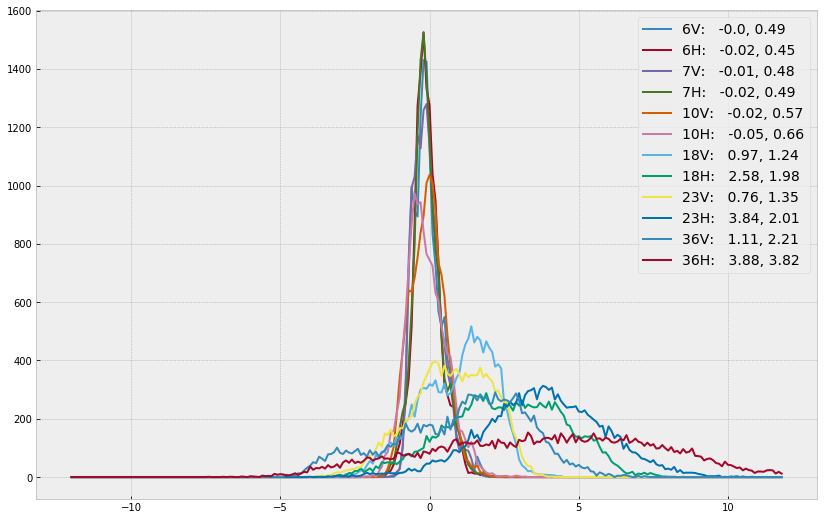

In [21]:
plt.style.use('bmh')

tbd = tb_obs - tb_sim

k=0
print(tbd[k,:], tp_sav[k],wi_sav[k],ss_sav[k])
k=2000
print(tbd[k,:], tp_sav[k],wi_sav[k],ss_sav[k])
k=3000
print(tbd[k,:], tp_sav[k],wi_sav[k],ss_sav[k])
k=1000
print(tbd[k,:], tp_sav[k],wi_sav[k],ss_sav[k])
#low = np.where(np.array(tp_sav)<14)  # testing
hx = np.arange(-12,12,.1)
p1 = plt.figure(figsize=[14,9])
outs = np.zeros([nch,2])
for c in range(nch)[:-2]:
    outs[c,:] = [round(np.mean(tbd[:,c]),2), round(np.std(tbd[:,c]),2)]
    print(ch_str[c]+': ', outs[c,:],'@ ', np.mean(tb_obs[:,c])) #, np.mean(tbd[low[0],c]))
    #print(c,np.min(tbd[:,c]), np.max(tbd[:,c]), np.mean(tbd[:,c]), np.std(tbd[:,c]))
    his = np.histogram(tbd[:,c], bins=hx)
    plt.plot(his[1][:-1], his[0], label=ch_str[c]+':   '+str(outs[c,0])+', '+str(outs[c,1]))
plt.legend(fontsize=14)
plt.savefig('img/AMSR2cal_'+dorb+'_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+err+'_'+tez+'.png', \
 bbox_inches="tight",transparent=True, dpi=250)
plt.show()
#andstophere

In [22]:
# save numpy arrays from fwd model simulations
chcut, lwcut = 0.5, 10
np.save('data/tbobs_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy', tb_obs) # points x nch
np.save('data/tbsim_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy', tb_sim)
np.save('data/sst_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy', ss_sav)
np.save('data/tpw_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy', tp_sav)
np.save('data/wind_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy', wi_sav)

In [23]:
# read in from numpy arrays:
# ['0.00E+2', '2.84E+2', '1.74E+2', '5.84E+1', (88512, 14)]
chcut, lwcut = 0.5, 10
tbo_in = np.load('data/tbobs_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy') # points x nch
tbs_in = np.load('data/tbsim_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy')
ss_in = np.load('data/sst_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy')
tp_in = np.load('data/tpw_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy')
wi_in = np.load('data/wind_'+str(chcut)+'chi_'+str(lwcut)+'lwp_'+dorb+'_'+err+'_'+tez+'.npy')
tbd_in = tbo_in-tbs_in

In [24]:
dexl = np.where(tp_in<15)[0]
dexm = np.logical_and(tp_in>15,tp_in<40)
dexh = np.where(tp_in>40)[0]
print(np.shape(dexl),np.shape(tp_in[dexm]),np.shape(dexh))
for c in range(nch):
    print(c, np.mean(tbd_in[:,c]), np.mean(tbd_in[dexl,c]), np.mean(tbd_in[dexm,c]), np.mean(tbd_in[dexh,c]))

(327,) (6814,) (6980,)
0 -0.0030113377293930934 1.3454737764354652 0.17676255311242584 -0.24168381975347084
1 -0.02248530569267892 0.7367218773699331 0.10784639040837324 -0.1852848653050061
2 -0.013175774910516502 1.1927147896850465 0.1661640099481319 -0.24474418589183158
3 -0.02406438199504524 0.7405868492233729 0.10982186422091608 -0.1905890000930371
4 -0.0153240385467989 0.7646840483429993 0.2308699163945823 -0.2922048771404286
5 -0.047393542412063144 0.5847176377716892 0.19299747976736462 -0.31168076032763736
6 0.9678861893290068 0.4500493492909931 1.6655221309622328 0.3111012810773776
7 2.5789718829429926 2.5673979255811283 3.758552309851291 1.4279867332444522
8 0.7580031369318522 -1.8866175380119514 1.142477763542931 0.5065677293356818
9 3.842108482256795 1.4137242790393574 4.561394027385185 3.253694432105972
10 1.1050167004407907 1.3930633254590716 2.6111627322874718 -0.37880426050251376
11 3.881897705117823 6.061666044030805 6.506861179663579 1.2172436417396961
12 0.93643900790

In [25]:
print(info(tbd[:,2]))
sev = tbd[:,2]
sevo= tb_obs[:,2]
np.shape(sev)
print(info(tb_obs[:,4]))

['-1.23E+0', '2.21E+0', '-1.32E-2', '4.78E-1']
['1.63E+2', '1.82E+2', '1.77E+2', '2.81E+0']


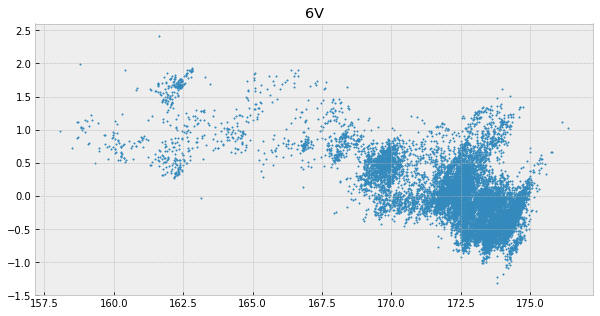

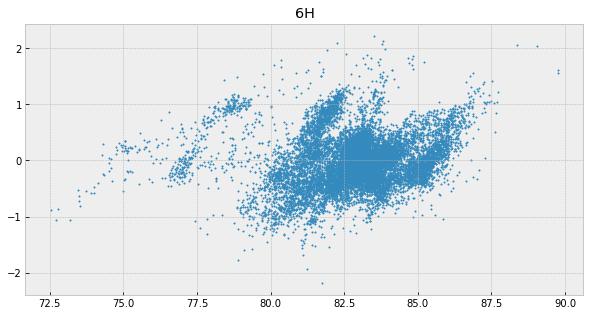

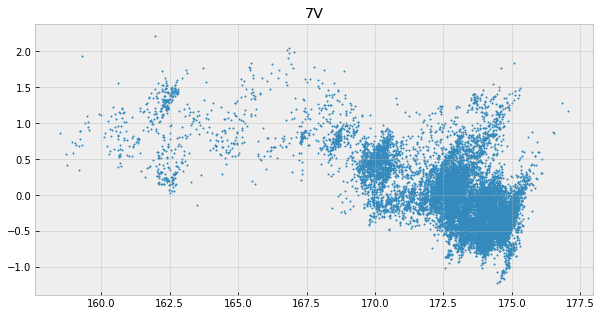

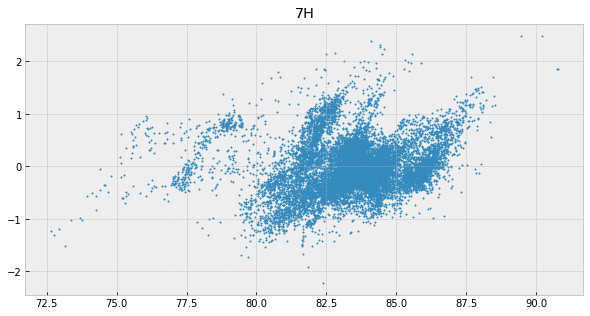

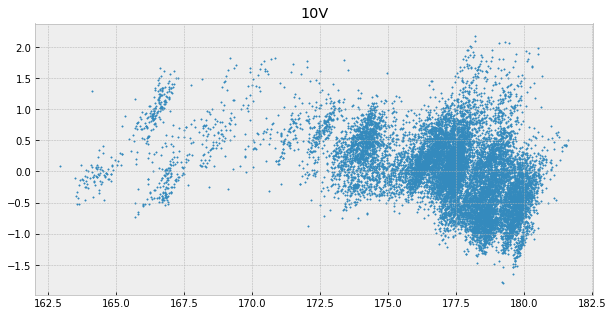

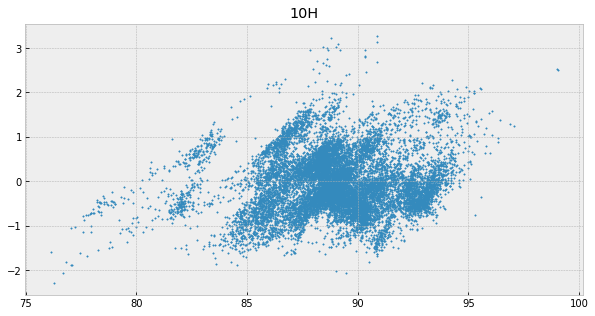

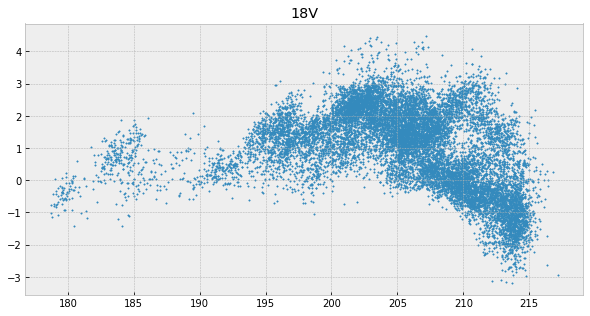

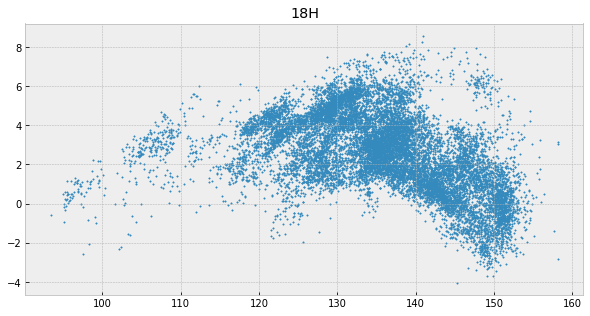

In [26]:
# output scatter plots (maybe with best fit lines?) of bias wrt Tb of scene:
for c in range(nch)[:-6]:
    p = plt.figure(figsize=[10,5])
    plt.scatter(tb_obs[:,c], tbd[:,c], s=2) #, title=ch_str)
    plt.title(ch_str[c])

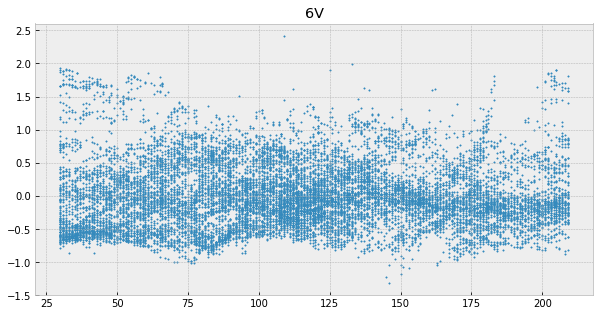

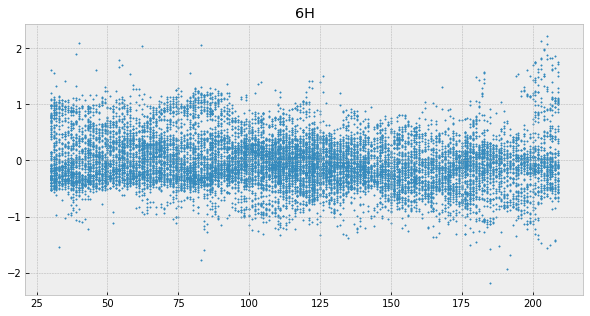

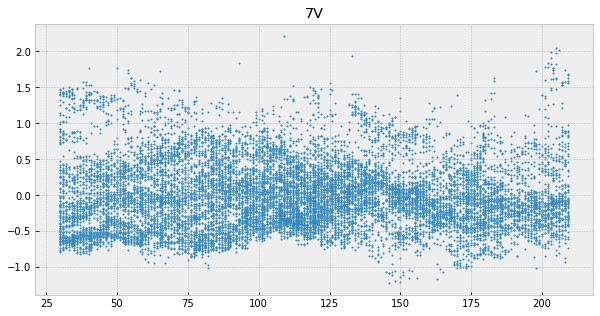

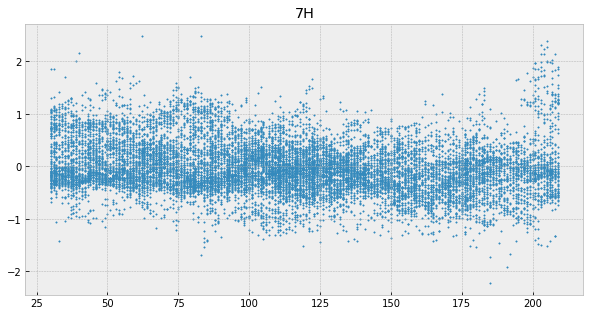

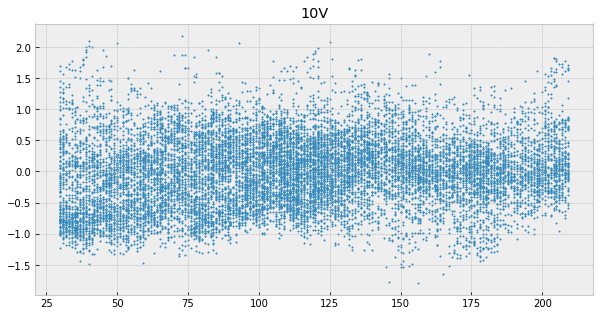

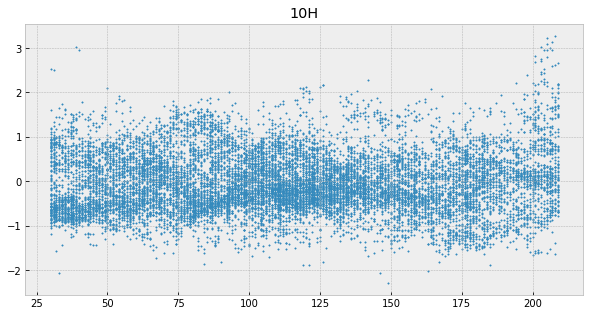

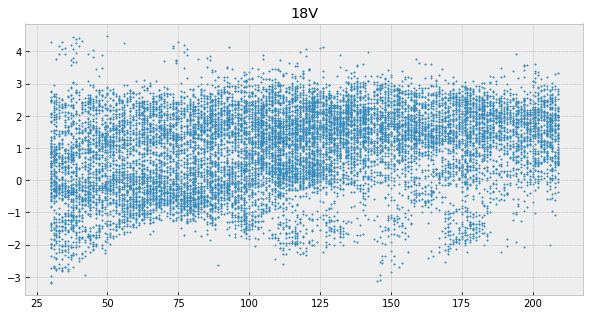

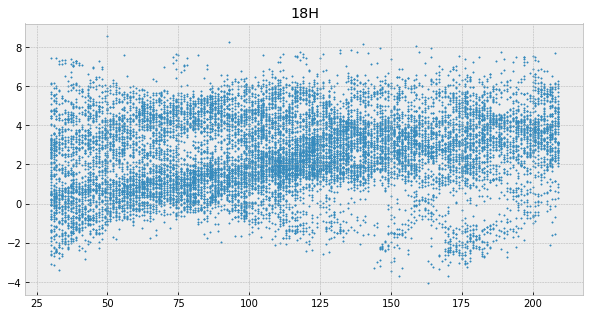

In [27]:
# output scatter plots (maybe with best fit lines?) of bias wrt Tb of scene:
for c in range(nch)[:-6]:
    p = plt.figure(figsize=[10,5])
    plt.scatter(sc_sav[:], tbd[:,c], s=2) #, title=ch_str)
    plt.title(ch_str[c])